### Kernel Density Estimation
Kernel Density Estimation or KDE for short is a technique to estimate the probability density function (PDF) of a random variable on observations. 

The basic idea behind kernel density estimation is to place a kernel function, typically a symmetric and non-negative function, at each data point and then sum up these kernel functions to obtain the estimated density. The kernel function acts as a weighting function that spreads out the influence of each data point to its neighboring points.

### Estimators:
__Input__: $N, X_{(n,)}, K$
  - N is the number of observations
  - x is a random variable
  - X is a vector of N observations
  - h is the bandwidth
  - K is the kernel function

The kernel density estimators of F will be:
$\hat{p}(x) = \frac{1}{nh}\sum_i^N K(\frac{X_i - x}{h})$

### Kernels:
- Rect: $1/2 * I(|u| <= 1)$
- Tri: $1 - |u| * I(|u| <= 1)$
- Par: $3/4 * (1 - u^2) * I(|u| <= 1)$
- Bit: $15/16 * (1 - u^2)^2 * I(|u| <= 1)$
- Gauss: $0.5 * I(|u| <= 1)$
- Silv: $0.5 * I(|u| <= 1)$

### MISE:
MISE is abbreviation of Mean Integrated Squared Error, this metric measure how well the KDE fits true PDF:

$MISE = \sum (p - \hat{p})^2$


### Cross validation unbiased risk
The CV Density Estimators is denoted: $\hat{p}_{n, -i}(x) = \frac{1}{(n - 1)h} \sum_{j, j \ne i}^N K(\frac{X_j - x}{h})$.

### Implementation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

(array([0.00163352, 0.00544505, 0.0201467 , 0.06479613, 0.10726754,
        0.14756093, 0.09474392, 0.06697415, 0.02776977, 0.00816758]),
 array([-10.45724178,  -8.62071234,  -6.7841829 ,  -4.94765346,
         -3.11112402,  -1.27459458,   0.56193486,   2.3984643 ,
          4.23499374,   6.07152318,   7.90805262]),
 <BarContainer object of 10 artists>)

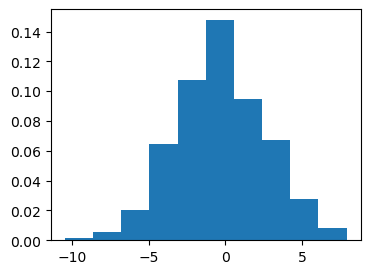

In [229]:
X = np.random.normal(size=1000, scale=3)
plt.figure(figsize=(4,3))
plt.hist(X, density=True)

In [230]:
def kernel(u, type: str):
    if type == "rect":
        return 1/2 * (np.abs(u) <= 1)
    elif type == "tri":
        return (1 - np.abs(u)) * (np.abs(u) <= 1)
    elif type == "par":
        return 3/4 * (1 - u**2) * (np.abs(u) <= 1)
    elif type == "bit":
        return 15/16 * (1 - u**2)**2 * (np.abs(u) <= 1)
    elif type == "gauss":
        return 1 / np.sqrt(2 * np.pi) * np.exp(-u**2 / 2)
    elif type == "silv":
        return 1/2 * np.exp(-np.abs(u) / np.sqrt(2)) * np.sin(np.abs(u) / np.sqrt(2) + np.pi/4)
    return None

In [231]:
def kde(X: np.array, x: float, h: float, k: str):
    f = 1 / (len(X) * h)
    s = np.sum(kernel((X - x) / h, k))
    return f * s

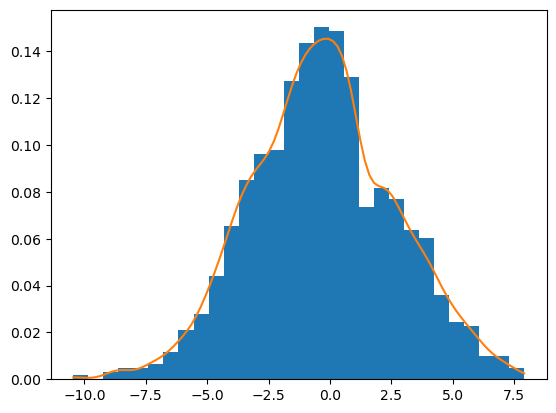

In [232]:
r = np.linspace(min(X), max(X), 100)
p_hat = [kde(X, x, 0.5, "gauss") for x in r]
plt.hist(X, bins=30, density=True)
plt.plot(r, p_hat)

### Mean Integrated Squared Error

In [300]:
def mise(X, R, h: float, k: str, pdf):
    p_true = pdf(R)
    p_hat = np.zeros_like(R)
    for i, x in enumerate(R):
        p_hat[i] = kde(X, x, h, k)
        
    return np.sum((p_true - p_hat) ** 2)
    
R = np.linspace(min(X), max(X), len(X))
H = np.linspace(0.01, 10, 100)
M = []
h_mise = 0
min_mise = 9999
for h in H:
    err = mise(X, R, h, "gauss", lambda x: stats.norm.pdf(x, scale=3))
    M.append(err)
    if err < min_mise:
        min_mise = err
        h_mise = h

In [301]:
print(f"h_argmin(MISE): {min_mise, h_mise}")

h_argmin(MISE): (0.05314520281102392, 1.1199999999999999)


Text(0.5, 1.0, 'MISE')

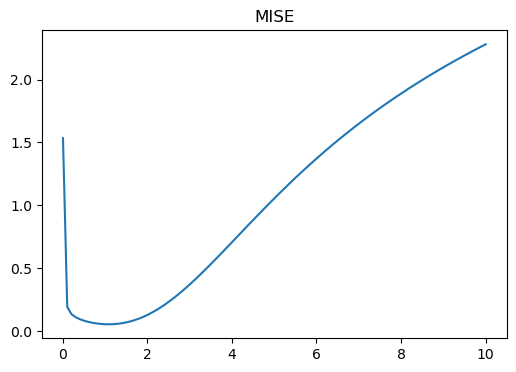

In [303]:
plt.figure(figsize=(6, 4))
plt.plot(H, M)
plt.title("MISE")

### CV Density Estimators

In [256]:
def kde_cv(X: np.array, x: float, h: float, k: str, j: int):
    n = len(X)
    f = 1 / ((len(X) - 1) * h)
    p = np.mean(kernel((x - X) / h, k))
    return p

In [293]:
def ubcv(X: np.array, h: float, k: str):
    n = len(X)
    r = np.linspace(min(X), max(X), n)
    p = np.zeros_like(r)
    g = np.zeros_like(r)
    for i, x in enumerate(r):
        p[i] = kde(X, x, h, k)

    for i, x in enumerate(r):
        g[i] = kde_cv(X, x, h, k, i)

    risk = np.mean((p - g)**2)
    return r, p, g, risk

100it [00:06, 15.46it/s]


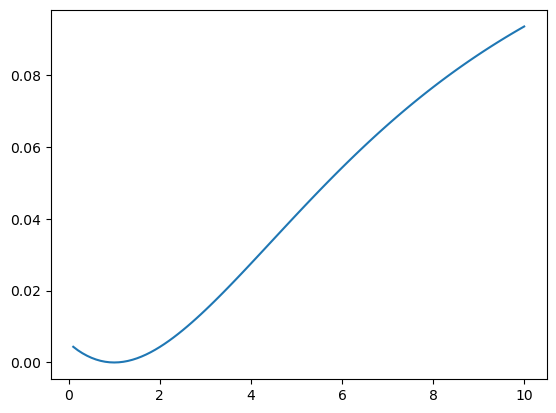

In [294]:
space = np.linspace(0.1, 10, 100)
risks = np.zeros_like(space)
for i, h in tqdm(enumerate(space)):
    R, P, G, risk = ubcv(X, h, "gauss")
    risks[i] = risk
plt.plot(space, risks)

In [287]:
def minimize_cv(X, k: str, search_space: list):
    min_risk = 9999
    min_h = 9999
    
    for h in tqdm(search_space):
        R, P, G, risk = ubcv(X, h, k)
        if risk < min_risk:
            min_h = h
            min_risk = risk
    
    return min_h, min_risk

In [288]:
h_cv, h_risk = minimize_cv(X, "gauss", np.linspace(0.01, 10, 100))

100%|██████████| 100/100 [00:06<00:00, 15.52it/s]


In [289]:
print(f"H_CV: {h_cv}")
print(f"Risk_CV: {h_risk}")

H_CV: 1.019090909090909
Risk_CV: 1.8060637398381584e-06
